# Pairwise Jacard

This is a notebook containing all of my experiments with neuron similarity and clustering on a more typical neural network example

## Imports and CUDA Verification

In [2]:
# Import necessary libraries
import torch.cuda as torch_cuda
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
from torchvision.utils import make_grid
from sklearn.manifold import TSNE

import shap
import random
import copy

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  
torch.backends.cudnn.deterministic = True 
torch.backends.cudnn.benchmark = False 

In [4]:
print('===VERIFY GPU===')

# If CUDA is available, print GPU details
if torch.cuda.is_available():
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0)} bytes")
    print(f"GPU Memory Cached: {torch.cuda.memory_reserved(0)} bytes")

# Select device: GPU if available, otherwise CPU
device = torch.device('cuda:0' if torch_cuda.is_available() else 'cpu')


===VERIFY GPU===
Number of GPUs: 1
GPU Name: NVIDIA RTX A4000
GPU Memory Allocated: 0 bytes
GPU Memory Cached: 0 bytes


## Model

Define an architecture for a neural network for a binary classification with 4 hidden layers each with 100 neurons.

In [5]:
batch_size = 64
num_epochs = 25
num_dimensions = 30

NEURON_NUMBER = 100

loss_fn = nn.BCELoss()

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(num_dimensions, NEURON_NUMBER),
            nn.ReLU(),

            nn.Linear(NEURON_NUMBER, NEURON_NUMBER),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Linear(NEURON_NUMBER, NEURON_NUMBER),
            nn.ReLU(),
            nn.Dropout(p=0.3),

            nn.Linear(NEURON_NUMBER, NEURON_NUMBER),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(NEURON_NUMBER, NEURON_NUMBER),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(NEURON_NUMBER, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc_layers(x)
        return x

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.unsqueeze(1).float().to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
                f" ({100.0 * batch_idx / len(train_loader):.0f}%)]"
                f"\tLoss: {loss.item():.6f}"
            )


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.unsqueeze(1).float().to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()  # sum up batch loss
            pred = (output > 0.5).float()  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(
        f"\nTest set: Average loss: {test_loss:.4f},"
        f" Accuracy: {correct}/{len(test_loader.dataset)}"
        f" ({100.0 * correct / len(test_loader.dataset):.3f}%)\n"
    )

model = Net().to(device)

## Dataset

We process the MNIST dataset with an autoencoder to reduce the features from 784 (28*28 image) into a user defined variable (in our case 30). We also only focus on 0s and 1s for a binary classification task.

In [6]:
encoder_epochs = 100
classes = [0,1]

class AutoEncoder(nn.Module):
    def __init__(self, encoding_dim):
        super(AutoEncoder, self).__init__()
        # Encoding from 784 (32*32) to an arbitary number of features
        # self.encoder = nn.Linear(784, encoding_dim)

        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim)
        )

        # Encoding to 784 (32*32) to an arbitary number of features
        # self.decoder = nn.Linear(encoding_dim, 784)

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),

            nn.Linear(64, 128),
            nn.ReLU(),

            nn.Linear(128, 256),
            nn.ReLU(),

            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784)
        )

    def forward(self, x):
        x = x.reshape(-1, 784)
        x = F.relu(self.encoder(x))
        x = self.decoder(x)
        return x
    
encoder = AutoEncoder(num_dimensions).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(encoder.parameters())

mnist_trainset = datasets.MNIST(
    "Dataset",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)

mnist_testset = datasets.MNIST(
    "Dataset",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)

train_indices = [i for i, label in enumerate(mnist_trainset.targets) if label in classes]
test_indices = [i for i, label in enumerate(mnist_testset.targets) if label in classes]

train_subset = Subset(mnist_trainset, train_indices)
test_subset = Subset(mnist_testset, test_indices)

train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_subset,
    batch_size=batch_size,
    shuffle=False
)

def train_autoencoder(epoch):
    train_loss = 0.0

    for data in train_loader:
        images, _ = data

        images = images.view(images.size(0), -1)
        images = images.to(device)

        optimizer.zero_grad()

        outputs = encoder(images)

        loss = criterion(outputs, images)

        loss.backward()

        optimizer.step()

        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch,
        train_loss
        ))

# Run the training and testing for defined epochs
for epoch in range(encoder_epochs):
    train_autoencoder(epoch)

Epoch: 0 	Training Loss: 2.987143
Epoch: 1 	Training Loss: 1.980655
Epoch: 2 	Training Loss: 1.609803
Epoch: 3 	Training Loss: 1.382348
Epoch: 4 	Training Loss: 1.306208
Epoch: 5 	Training Loss: 1.234536
Epoch: 6 	Training Loss: 1.164006
Epoch: 7 	Training Loss: 1.115515
Epoch: 8 	Training Loss: 1.073605
Epoch: 9 	Training Loss: 1.048264
Epoch: 10 	Training Loss: 1.039164
Epoch: 11 	Training Loss: 1.027177
Epoch: 12 	Training Loss: 0.996576
Epoch: 13 	Training Loss: 0.982713
Epoch: 14 	Training Loss: 0.961470
Epoch: 15 	Training Loss: 0.930140
Epoch: 16 	Training Loss: 0.907103
Epoch: 17 	Training Loss: 0.892509
Epoch: 18 	Training Loss: 0.875176
Epoch: 19 	Training Loss: 0.822077
Epoch: 20 	Training Loss: 0.774352
Epoch: 21 	Training Loss: 0.745955
Epoch: 22 	Training Loss: 0.727370
Epoch: 23 	Training Loss: 0.713460
Epoch: 24 	Training Loss: 0.709098
Epoch: 25 	Training Loss: 0.695871
Epoch: 26 	Training Loss: 0.690534
Epoch: 27 	Training Loss: 0.670564
Epoch: 28 	Training Loss: 0.66

In [19]:
torch.save(encoder, 'Models/encoder.pth')

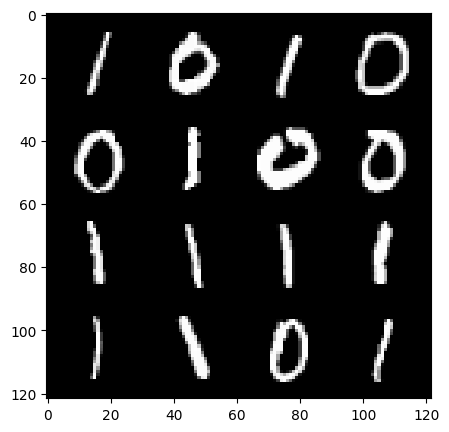

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17339838..1.18863].


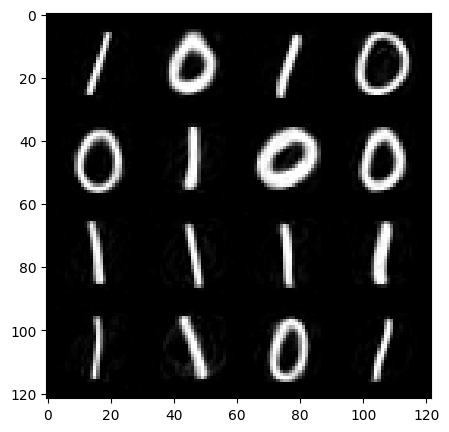

In [7]:
from torchvision.utils import make_grid
plt.rcParams["figure.figsize"] = [5, 5]

def imshow(img):
    npimg = img.numpy()
    #transpose: change array axis to correspond to the plt.imshow() function     
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()

# load 16 images from testset
inputs, _ = next(iter(test_loader))
inputs_example = make_grid(inputs[:16,:,:,:],4)
imshow(inputs_example)

#convert from image to tensor
inputs=torch.reshape(inputs,(-1,784))

# get the outputs from the trained model
outputs=encoder(inputs.to(device)).to('cpu')

#convert from tensor to image
outputs=torch.reshape(outputs,(-1,1,28,28))
outputs=outputs.detach().cpu()

#show the output images
outputs_example = make_grid(outputs[:16,:,:,:],4)
imshow(outputs_example)

In [8]:
def encode_dataset():
    encoder.eval()
    train_features = []
    train_labels = []
    test_features = []
    test_labels = []

    with torch.no_grad():
      for data, label in train_loader:
          # Get the encoded features (latent space representation)
          encoded = encoder.encoder(data.view(-1, 28 * 28).to(device))
          train_features.append(encoded.to('cpu'))
          train_labels.append(label)

      for data, label in test_loader:
          # Get the encoded features (latent space representation)
          encoded = encoder.encoder(data.view(-1, 28 * 28).to(device))
          test_features.append(encoded.to('cpu'))
          test_labels.append(label)

    return torch.cat(train_features, dim=0), torch.cat(test_features, dim=0), torch.cat(train_labels, dim=0), torch.cat(test_labels, dim=0)

features_to_train, features_to_test, labels_to_train, labels_to_test = encode_dataset()

train_dataset = torch.utils.data.TensorDataset(features_to_train, labels_to_train)
test_dataset = torch.utils.data.TensorDataset(features_to_test, labels_to_test)

encoded_dataset_full = np.concat([features_to_train.numpy(), features_to_test.numpy()])

Load the new encoded dataset into a DataLoader for the neural net

In [9]:
encoded_trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
encoded_testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Train

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, encoded_trainloader, optimizer, epoch)
    test(model, device, encoded_testloader)

Train Epoch: 1 [0/12665 (0%)]	Loss: 0.694831
Train Epoch: 1 [3200/12665 (25%)]	Loss: 0.691917
Train Epoch: 1 [6400/12665 (51%)]	Loss: 0.687210
Train Epoch: 1 [9600/12665 (76%)]	Loss: 0.675626

Test set: Average loss: 0.0103, Accuracy: 1697/2115 (80.236%)

Train Epoch: 2 [0/12665 (0%)]	Loss: 0.627376
Train Epoch: 2 [3200/12665 (25%)]	Loss: 0.592021
Train Epoch: 2 [6400/12665 (51%)]	Loss: 0.538211
Train Epoch: 2 [9600/12665 (76%)]	Loss: 0.337561

Test set: Average loss: 0.0035, Accuracy: 2104/2115 (99.480%)

Train Epoch: 3 [0/12665 (0%)]	Loss: 0.294647
Train Epoch: 3 [3200/12665 (25%)]	Loss: 0.230403
Train Epoch: 3 [6400/12665 (51%)]	Loss: 0.210129
Train Epoch: 3 [9600/12665 (76%)]	Loss: 0.118981

Test set: Average loss: 0.0013, Accuracy: 2107/2115 (99.622%)

Train Epoch: 4 [0/12665 (0%)]	Loss: 0.131750
Train Epoch: 4 [3200/12665 (25%)]	Loss: 0.098000
Train Epoch: 4 [6400/12665 (51%)]	Loss: 0.102425
Train Epoch: 4 [9600/12665 (76%)]	Loss: 0.063455

Test set: Average loss: 0.0006, Accurac

In [20]:
torch.save(model, 'Models/model.pth')

## SHAP

Produce SHAP explanations of the input features, so we can create vectors of important features later

In [75]:
# Method to generate hidden layer SHAP values

def create_SHAP_explainer(layers, background,layer=5):
    first_half = layers[0:layer]
    second_half = layers[layer:]
    e = shap.DeepExplainer(second_half, first_half(background))
    return e, first_half, second_half

In [11]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(encoded_testloader))
images, _ = batch

background = images[:61]
test_images = images[61:64]

model.to('cpu')

In [137]:
e, first_half, second_half = create_SHAP_explainer(layers=model.fc_layers, background=background, layer=11)

shap_values_train = e.shap_values(first_half(features_to_train))
shap_values_test = e.shap_values(first_half(features_to_test))
shap_values = np.concatenate((shap_values_train, shap_values_test), axis=0)
labels = np.concatenate((labels_to_train, labels_to_test), axis=0)

shap_values = shap_values.reshape((14780, NEURON_NUMBER))

In [141]:
model

Net(
  (fc_layers): Sequential(
    (0): Linear(in_features=30, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=100, out_features=100, bias=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.4, inplace=False)
    (11): Linear(in_features=100, out_features=100, bias=True)
    (12): ReLU()
    (13): Dropout(p=0.5, inplace=False)
    (14): Linear(in_features=100, out_features=1, bias=True)
    (15): Sigmoid()
  )
)

In [136]:
model.fc_layers[11:]

Sequential(
  (11): Linear(in_features=100, out_features=100, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=100, out_features=1, bias=True)
  (15): Sigmoid()
)

In [138]:
columns = [f'feature_{x}' for x in range(0,NEURON_NUMBER)]

shap_values_df = pd.DataFrame(shap_values, columns=columns)
labels_df = pd.DataFrame(labels, columns=['class'])

In [140]:
shap_values_df.to_csv('Data/SHAP_Values_fourth_hidden_layer.csv', index=True, index_label='ind')

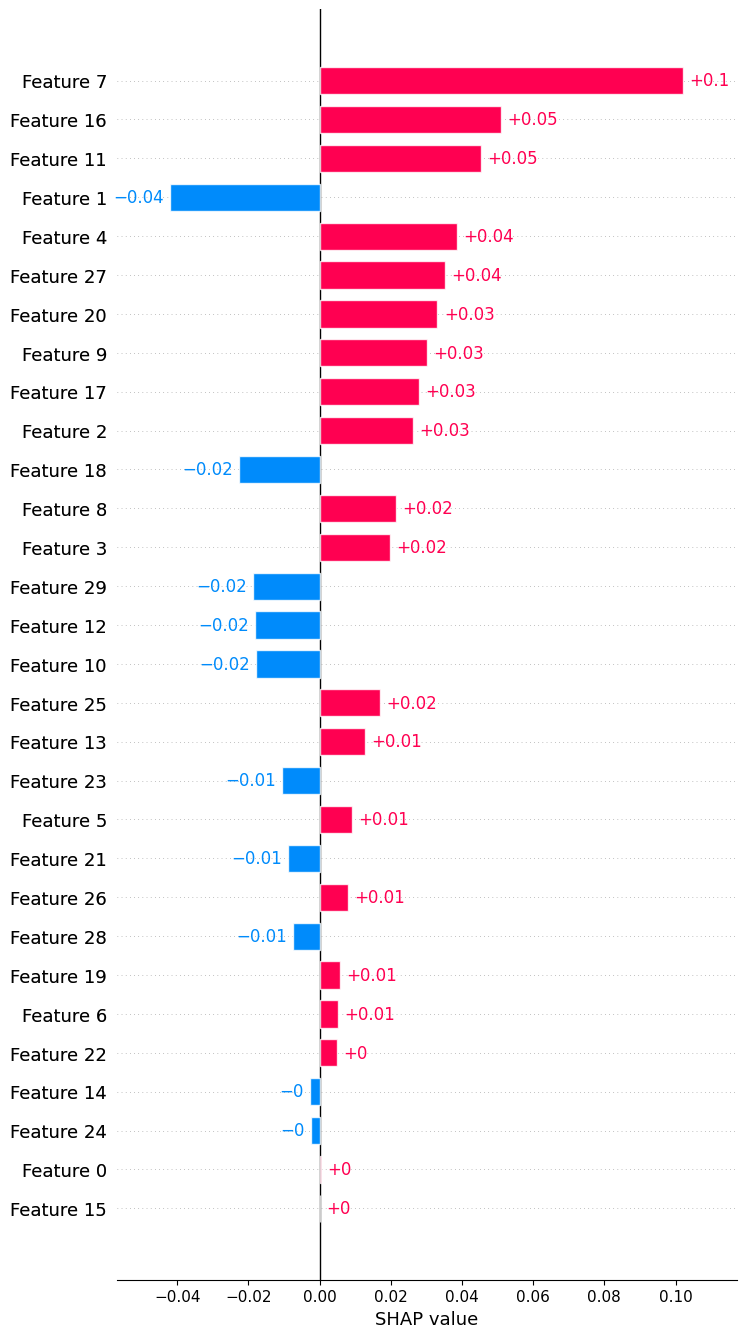

In [14]:
shap.plots.bar(shap.Explanation(shap_values[1]), max_display=num_dimensions)

In [15]:
columns = [f'feature_{x}' for x in range(0,num_dimensions)]

shap_values_df = pd.DataFrame(shap_values, columns=columns)
labels_df = pd.DataFrame(labels, columns=['class'])

shap_values_df = shap_values_df.join(labels_df)
#shap_values_df.to_csv('Data/shap_values.csv', index=None)

In [17]:
shap_values_2d = TSNE(n_components=2, random_state=0, metric='cosine').fit_transform(shap_values)
shap_values_2d_df = pd.DataFrame(shap_values_2d, columns=['x','y']).join(labels_df)
#shap_values_2d_df.to_csv('Data/shap_values_2d_20-features_4-2-25_FIXED-42.csv', index=None)

In [18]:
shap_values_2d_df

,x,y,class
0,-47.160130,-24.128881,0
1,22.479898,-51.934200,1
2,6.978034,78.863968,1
3,25.556274,49.504410,1
4,16.858538,62.061920,1
...,...,...,...
14775,18.397976,-60.198624,1
14776,-28.739857,21.507500,0
14777,60.598698,27.656067,1
14778,-46.974705,15.334579,0


### Quick Plot

<Axes: xlabel='x', ylabel='y'>

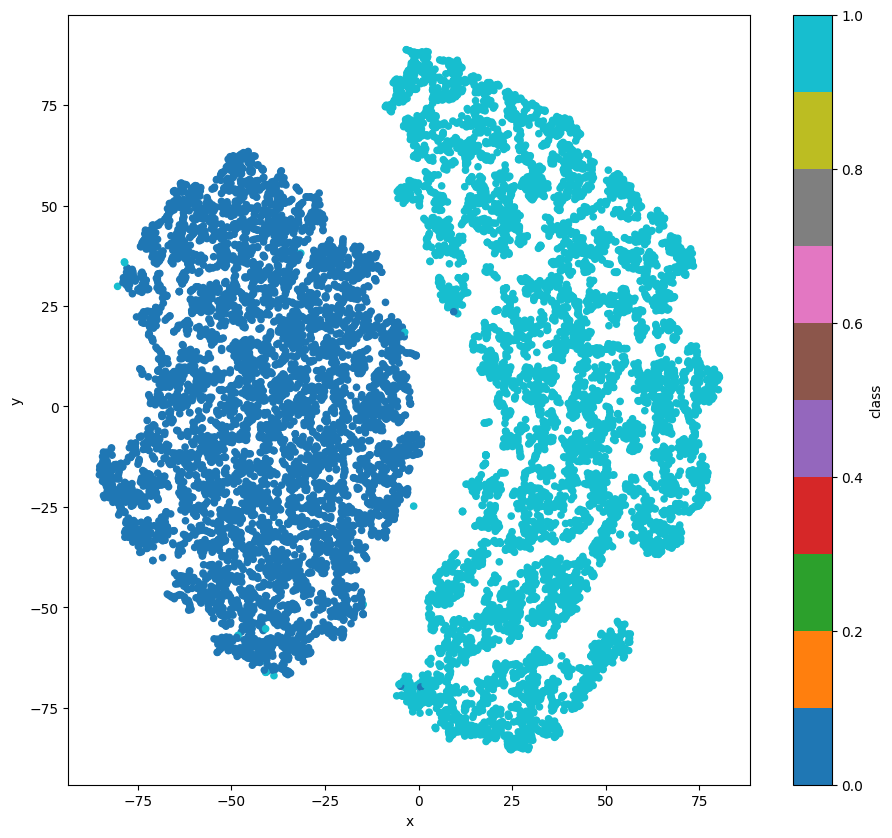

In [19]:
plt.rcParams["figure.figsize"] = [11, 10]
shap_values_2d_df.plot.scatter(
    x='x',
    y='y',
    c='class',
    colormap='tab10'
)

## Inter-Layer SHAP Values

In [93]:
model.fc_layers[11:]

Sequential(
  (11): Linear(in_features=100, out_features=100, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=100, out_features=1, bias=True)
  (15): Sigmoid()
)

In [96]:
e_first_layer, fl_first_half, fl_second_half = create_SHAP_explainer(model.fc_layers, background)
e_second_layer, sl_first_half, sl_second_half = create_SHAP_explainer(model.fc_layers, background, layer=8)
e_third_layer, tl_first_half, tl_second_half = create_SHAP_explainer(model.fc_layers, background, layer=11)

### Quick Plots

In [ ]:
shap_values_first_layer = e_first_layer.shap_values(fl_first_half(test_images)).reshape((3,100))
shap_values_second_layer = e_second_layer.shap_values(sl_first_half(test_images)).reshape((3,100))
shap_values_third_layer = e_third_layer.shap_values(tl_first_half(test_images)).reshape((3,100))

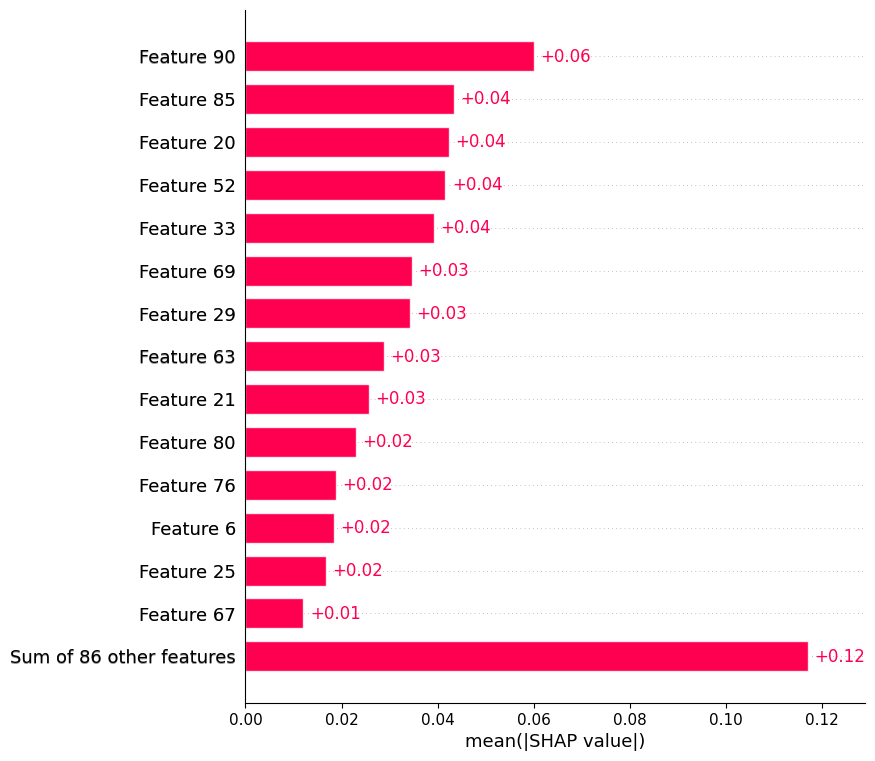

In [ ]:
shap.plots.bar(shap.Explanation(shap_values_first_layer), max_display=15)

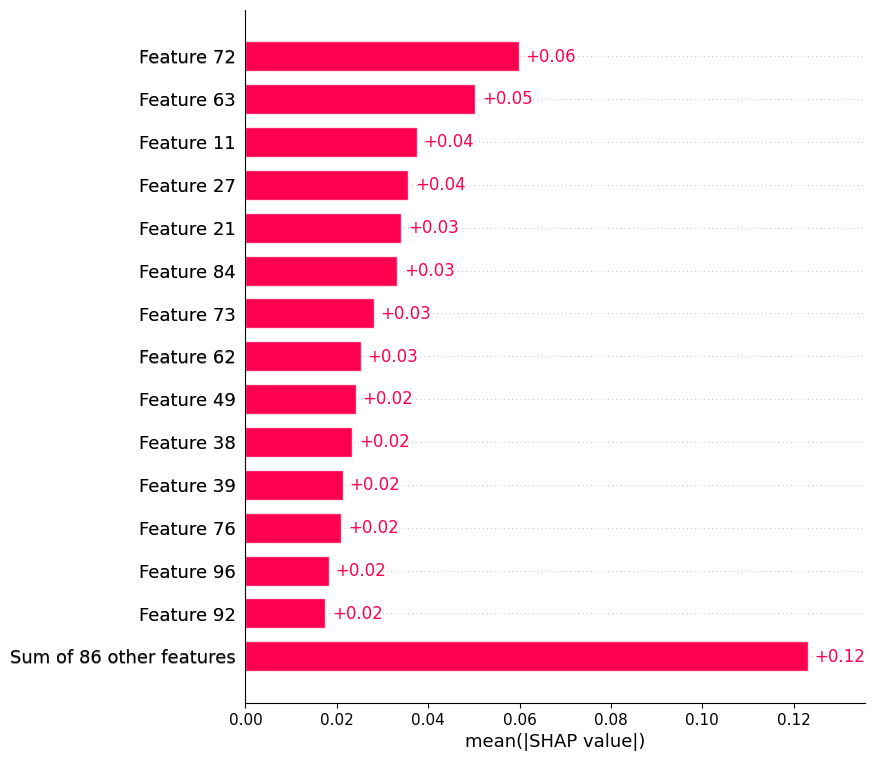

In [98]:
shap.plots.bar(shap.Explanation(shap_values_second_layer), max_display=15)

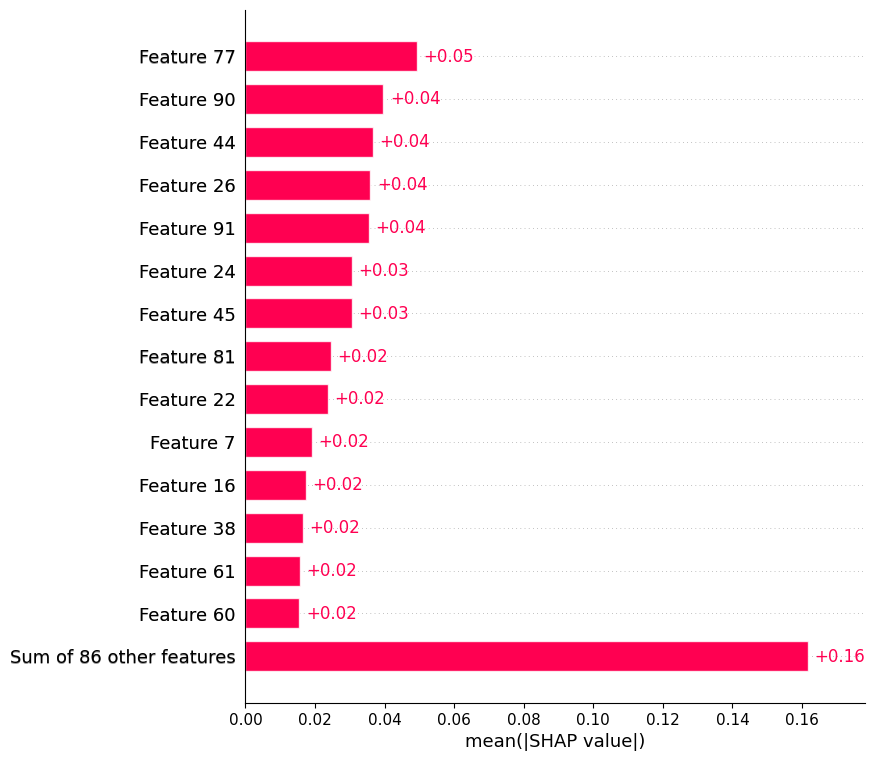

In [99]:
shap.plots.bar(shap.Explanation(shap_values_third_layer), max_display=15)

## Clustering

In [20]:
def jacard(set1, set2):
    return len(set1.intersection(set2)) / len(set1.union(set2))

def compute_sim_matrix(activations):
    full_similarity_matrix = []
    for x in range(0, len(activations)):
        similarity_scores = []
        for z in range(0, len(activations)):
            if x == z:
                similarity_scores.append(1)
            else:
                similarity_scores.append(jacard(set(activations[x]), set(activations[z])))
        full_similarity_matrix .append(similarity_scores)
    return  np.array(full_similarity_matrix )

In [21]:
"""
Structure:
    - Cluster 0
    - Cluster 1
    - Cluster 2
"""

clusters_2 = [
    [18, 209, 437, 492, 588, 929, 973, 1028, 1513, 1668, 1677, 1754, 1893, 2333, 2404, 2449, 2594, 2664,3133, 3225, 3240, 3381, 3878, 3995, 4097, 4409, 4432, 4806, 4974, 5120, 5247, 5444, 5490, 5524, 6092, 6182, 6263, 6643, 6654, 6794, 6820, 7054, 7146, 7318, 7370, 7474,7545, 7597, 7810, 7827, 7840, 8209, 8380, 8635, 8640, 8809, 9155, 9528, 9662, 9664, 9972, 10263, 10589, 10692, 10764, 10767, 10773, 10774, 10775, 10781, 10788, 10791, 10796, 11040, 11545, 11876, 12195, 12273, 12670, 12863, 12974, 13120, 13300, 14105],
    [65, 397, 479, 568, 613, 752, 922, 1413, 2011, 2190, 2322, 2390, 2396, 2771, 2823, 3230, 3302, 3595, 4221, 4457, 4570, 4862, 5530, 5793, 5974, 6044, 6382, 6626, 6984, 7334, 7386, 7559,8031, 8124, 8406, 8600, 8892, 9387, 9447, 9465, 9584, 9635, 9914, 10279, 10557, 10592, 10815, 11087, 11309, 11392, 11745, 11791, 11937, 12176, 12790, 12814, 12909, 13237, 13291, 13326, 13389, 13504, 13617, 13659, 14658, 14666],
    [122, 150, 295, 721, 1362, 1644, 1786, 1806, 2143, 2259, 2292, 2623, 2628, 2630, 2632, 2642, 2650, 2749, 2765, 2770, 2777, 2779, 2781, 2790, 2806, 2815, 2818, 2844, 2959, 3274, 3339, 3345, 3419, 3970, 4043, 4374, 4797, 4816, 4817, 4884, 4907, 4910, 5056, 6204, 6208, 6364, 6367, 6371, 6385, 6397, 6400, 6405, 6409, 6415, 6420, 6653, 6673, 6894, 6897, 7009, 7013, 7062, 7063, 7261, 7262, 7372, 7403, 7531, 7638, 7656, 7657, 7787, 7825, 8092, 8171, 8177, 8323, 8330, 8340, 8352, 8540, 8547, 8620, 8663, 8671, 8678, 8777, 8780, 8798, 8803, 8810, 8816, 8819, 8835, 8859, 9188, 9191, 9210, 9216, 9378, 9384, 9389, 9432, 10424, 10428, 10431, 10433, 10441, 10443, 10498, 10512, 10518, 10520, 11037, 11061, 11439, 11618, 11633, 12153, 12167, 12169, 12526, 12613, 12656, 14232, 14561, 14723]
]

In [22]:
model.fc_layers

Sequential(
  (0): Linear(in_features=30, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Dropout(p=0.2, inplace=False)
  (5): Linear(in_features=100, out_features=100, bias=True)
  (6): ReLU()
  (7): Dropout(p=0.3, inplace=False)
  (8): Linear(in_features=100, out_features=100, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.4, inplace=False)
  (11): Linear(in_features=100, out_features=100, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=100, out_features=1, bias=True)
  (15): Sigmoid()
)

Add hooks to each of the hidden layers, so we can extract the activation maps for each cluster

In [23]:
model.cpu()

def get_activation(model):
    activations = [[],[],[],[]]
    hooks = []

    def hook1(model, input, output):
        activations[0].append(output.detach().numpy())

    def hook2(model, input, output):
        activations[1].append(output.detach().numpy())

    def hook3(model, input, output):
        activations[2].append(output.detach().numpy())

    def hook4(model, input, output):
        activations[3].append(output.detach().numpy())

    hooks.append(model.fc_layers[3].register_forward_hook(hook1))
    hooks.append(model.fc_layers[6].register_forward_hook(hook2))
    hooks.append(model.fc_layers[9].register_forward_hook(hook3))
    hooks.append(model.fc_layers[12].register_forward_hook(hook4))      
    return activations, hooks

cluster_num = 1
activations, hooks = get_activation(model)

for id in clusters_2[cluster_num]:
    out = model(torch.Tensor(encoded_dataset_full[id]))
activations = np.array(activations)

for hook in hooks:
    hook.remove()

In [24]:
layer_num = 0
trans_activations = activations[layer_num].transpose()

shap_snip = pd.read_csv('Data/shap_values.csv').drop(['class'], axis=1)
top_10_entries = []
class_leaning = []
top_10_average = []
neuron_shap_vectors_m1 = [] # Method One - Vector from Top 3 SHAP values for each header across all values
neuron_shap_vectors_m2 = [] # Method Two - Vector from the SHAP values of the top 3 activations

for x in range(0,len(trans_activations)):
    top_10 = np.argsort(trans_activations[x])[-10:][::-1]
    top_10_set = top_10[0:10]
    top_10_values = trans_activations[top_10]

    top_10_average.append(np.average(top_10_values))

    top_10_entries.append(top_10_set)
    shap_values_set = shap_snip.loc[top_10_set]

    neuron_shap_vectors_m1.append([shap_values_set[col].nlargest(3).values for col in shap_snip.columns])
    neuron_shap_vectors_m2.append([shap_values_set[col].iloc[:3].values for col in shap_snip.columns ])

    classes = [labels[clusters_2[cluster_num][z]] for z in top_10_set] # CHANGE THIS VALUE DEPENDING ON THE CLUSTER
    class_leaning.append(sum(classes)/len(classes))


In [25]:
similarity_matrix = compute_sim_matrix(top_10_entries)
#np.save('Matrices/cluster_one_similarity', similarity_matrix)
reduced_sim_matrix = TSNE(n_components=2, metric='cosine', random_state=0, perplexity=10).fit_transform(similarity_matrix)

In [26]:
class_leaning_df = pd.DataFrame(class_leaning, columns=['class_association'])
average_activation_df = pd.DataFrame(top_10_average, columns=['average_activation'])
top_10_entries_df = pd.DataFrame(top_10_entries, columns=[f'activation_{x}' for x in range(0, 10)])

coordinates = pd.DataFrame(reduced_sim_matrix, columns=['x','y']).join(class_leaning_df).join(top_10_entries_df).join(average_activation_df)
coordinates

,x,y,class_association,activation_0,activation_1,activation_2,activation_3,activation_4,activation_5,activation_6,activation_7,activation_8,activation_9,average_activation
0,-23.591976,-10.722050,0.1,65,64,63,62,61,60,59,58,57,56,0.255353
1,18.249987,11.146194,0.1,51,9,43,13,14,60,30,34,10,6,0.355027
2,-23.591976,-10.722050,0.1,65,64,63,62,61,60,59,58,57,56,0.255353
3,-23.591976,-10.722050,0.1,65,64,63,62,61,60,59,58,57,56,0.255353
4,-2.717016,-3.645230,0.1,14,15,36,31,56,24,55,65,64,61,0.277814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-25.423494,-7.086464,0.1,65,64,63,62,61,60,59,58,57,56,0.255353
96,1.127984,-0.711067,0.3,14,27,58,26,29,2,3,31,61,24,0.213125
97,-24.596706,-12.033295,0.1,65,64,63,62,61,60,59,58,57,56,0.255353
98,2.704217,2.947125,0.0,28,26,42,2,11,63,35,49,0,21,0.127683


In [93]:
coordinates.to_csv('Data/Neuron_Cluster_Third_Hidden_Layer.csv', index_label='ind')

### Quick Plot

<Axes: xlabel='x', ylabel='y'>

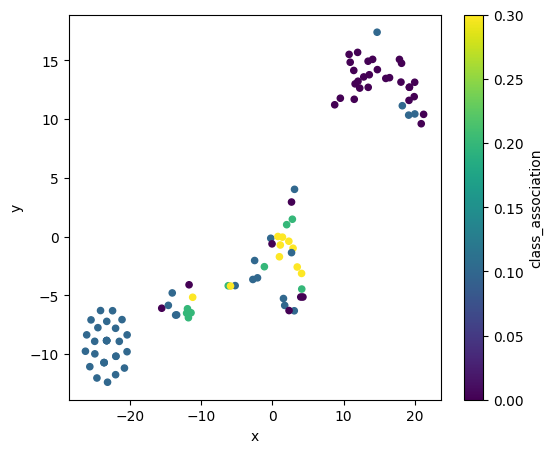

In [27]:
plt.rcParams["figure.figsize"] = [6,5]

coordinates.plot.scatter(
    x='x',
    y='y',
    c='class_association'
)

## Network-Wide Jacard

Apply the same code as before but for every neuron across every layer

In [172]:
first = pd.read_csv('Data/Neuron_Cluster_First_Hidden_Layer.csv')
first['layer'] = 1

second = pd.read_csv('Data/Neuron_Cluster_Second_Hidden_Layer.csv')
second['ind'] = second['ind'] + 100
second['layer'] = 2

third = pd.read_csv('Data/Neuron_Cluster_Third_Hidden_Layer.csv')
third['ind'] = third['ind'] + 200
third['layer'] = 3

fourth = pd.read_csv('Data/Neuron_Cluster_Last_Hidden_Layer.csv')
fourth['ind'] = fourth['ind'] + 300
fourth['layer'] = 4

full = pd.concat([first, second, third, fourth]).reset_index().drop('index', axis=1)
activations = full[[f'activation_{x}' for x in range(0,10)]].to_numpy()

In [ ]:
full_similarity_matrix  = compute_sim_matrix(activations)
reduced_sim_matrix = TSNE(n_components=2, metric='cosine', random_state=0, perplexity=10).fit_transform(full_similarity_matrix)
coordinates = pd.DataFrame(reduced_sim_matrix, columns=['x','y'])

info = full[['class_association', 'average_activation', 'layer']]
coordinates = coordinates.join(activations).join(info)

coordinates.to_csv('Data/Neuron_Cluster_All_Layers.csv')

### Quick Plot

<Axes: xlabel='x', ylabel='y'>

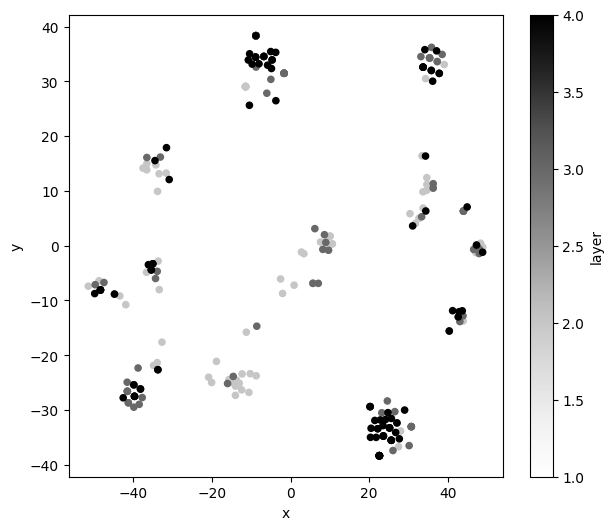

In [187]:
plt.rcParams["figure.figsize"] = [7,6]

coordinates.plot.scatter(
    x='x',
    y='y',
    c='average_activation'
)

## Vectors

USED METHOD TWO

In [75]:
neuron_shap_vectors_1 = np.abs(np.array(neuron_shap_vectors_m1))
neuron_shap_vectors_2 = np.abs(np.array(neuron_shap_vectors_m2))

In [78]:
threshold = 0.05
indexes = range(0,100)
columns = shap_snip.columns

to_print = 1

vectors = []
for ind in indexes:
    if ind == to_print:
        print(f'NEURON {ind + 1} VECTORS:\n')
    count = 0
    vector = []
    for x in range(0, len(columns)):
        important = any(i >= threshold for i in neuron_shap_vectors_2[ind][x])
        vector.append(int(important))
        if important:
            count += 1
        if ind == to_print:
            print(f'Column: {columns[x]:20s}Vector: {neuron_shap_vectors_2[ind][x]}\tImportant: {'Y' if important else 'N'}\n')
    vectors.append(vector)
    if ind == to_print:
        print(f'TOTAL IMPORTANT FEATURES: {count}/40')
        print('\n')

vectors_df = pd.DataFrame(vectors, columns=shap_snip.columns)

NEURON 2 VECTORS:

Column: feature_0           Vector: [0.04386569 0.01514574 0.05031261]	Important: Y

Column: feature_1           Vector: [0.02731769 0.01483643 0.00945872]	Important: N

Column: feature_2           Vector: [0.05673957 0.02413805 0.01542525]	Important: Y

Column: feature_3           Vector: [0.00371267 0.00074037 0.00143888]	Important: N

Column: feature_4           Vector: [2.68243230e-03 1.77183771e-03 9.58739547e-05]	Important: N

Column: feature_5           Vector: [0.01810136 0.00635437 0.00476178]	Important: N

Column: feature_6           Vector: [0.00047001 0.00050194 0.00041717]	Important: N

Column: feature_7           Vector: [0.01066022 0.0043485  0.00116778]	Important: N

Column: feature_8           Vector: [0.00969111 0.02334506 0.01029559]	Important: N

Column: feature_9           Vector: [0.00399532 0.00135842 0.00214848]	Important: N

Column: feature_10          Vector: [0.03085457 0.01348017 0.0126857 ]	Important: N

Column: feature_11          Vector

In [73]:
vectors_df.to_csv('Vectors/binary_vectors_cluster_1_last_hidden_layer.csv', index=False)

## Weight Manipulation

In [156]:
threshold = 0.2 # Threshold neuron activations should be above to be considered important
increment = 1

cluster_points = pd.read_csv('Data/Neuron_Cluster_1_First_Hidden_Layer.csv').drop(['ind','x','y','activation_0',	'activation_1',	'activation_2',	'activation_3',	'activation_4',	'activation_5',	'activation_6',	'activation_7',	'activation_8',	'activation_9'], axis=1)
important_neurons = cluster_points[cluster_points['average_activation'] > threshold].index
important_neuron_vectors = pd.read_csv('Vectors/binary_vectors_cluster_1_first_hidden_layer.csv').iloc[important_neurons].to_numpy()

In [162]:
weights = model.state_dict()
for name, param in weights.items():
    print(name,' - ' , param.shape)

fc_layers.0.weight  -  torch.Size([100, 30])
fc_layers.0.bias  -  torch.Size([100])
fc_layers.2.weight  -  torch.Size([100, 100])
fc_layers.2.bias  -  torch.Size([100])
fc_layers.5.weight  -  torch.Size([100, 100])
fc_layers.5.bias  -  torch.Size([100])
fc_layers.8.weight  -  torch.Size([100, 100])
fc_layers.8.bias  -  torch.Size([100])
fc_layers.11.weight  -  torch.Size([100, 100])
fc_layers.11.bias  -  torch.Size([100])
fc_layers.14.weight  -  torch.Size([1, 100])
fc_layers.14.bias  -  torch.Size([1])


In [158]:
important_neurons

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 15, 16, 17, 19, 20,
       21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 37, 38, 39, 40, 41,
       42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 60, 61, 62,
       63, 65, 66, 68, 69, 71, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 88, 89, 90, 91, 93, 95, 96, 97, 99],
      dtype='int64')

In [150]:
len(columns)

30

In [151]:
print(weights['fc_layers.0.weight'].shape)

torch.Size([100, 30])


In [159]:
weights_np = weights['fc_layers.0.weight'].numpy()

for i in range(0, len(important_neurons)):
    vector = important_neuron_vectors[i]
    for x in range(0, len(columns)):
        if vector[x]:
            weights_np[i][x] += increment

weights_np
weights['fc_layers.0.weight'] = torch.Tensor(weights_np)

model_copy = copy.deepcopy(model)
model_copy.load_state_dict(weights)

<All keys matched successfully>

In [160]:
test(model_copy, device=torch.device('cpu'), test_loader=encoded_testloader)


Test set: Average loss: 0.0001, Accuracy: 2109/2115 (99.716%)



In [163]:
test(model, device=torch.device('cpu'), test_loader=encoded_testloader)


Test set: Average loss: 0.0001, Accuracy: 2109/2115 (99.716%)

